- This notebook demonstrates the numerical results from Section 3. The code is designed to be user-friendly and can be used to analyze any antibiotic data with a selection of PD models. The user can choose a PD model and input their own PK and PD parameters. The code outputs, among other things, the value of $\tilde{D}$, an analytic and numerical analysis of the concavity of the Hill function as performed in this paper, and plots of the dose response curve, the treatment regimens, and the bacteria population curves.
- Run import cell, toggle parameters, then run second cell.
- Last modified 2 May 2025.
- Requirements: NumPy, SciPy, Matplotlib, python (any modern version)

In [2]:
import drug_parameters as par  # parameter class
import functions as fun  # functions

# Edit the paramaters, then run the cell

    Antibiotic: Ciprofloxacin
    PD Model: Regoes
--------------------------------------------------------------------------------
D_tilde (Inflection point): 0.007735615865315817 mg/L
AUC of Periodic Regimen: 1.776429176362988 mg*h/L
Continuous Regimen Concentration: 0.29607152939383136 mg/L
Infusion Rate for Continuous Regimen: 62.17502117270458 mg/h
--------------------------------------------------------------------------------
Max Periodic Regimen Concentration: 0.47619047619047616 mg/L
Min Periodic Regimen Concentration: 0.16835875742536846 mg/L

--------------------------------------------------------------------------------
           Check which regimen performs better with concavity analysis:
--------------------------------------------------------------------------------
D_min >= D_tilde, so the continuous regimen will perform better

--------------------------------------------------------------------------------
                Check which regimen performs better numerica

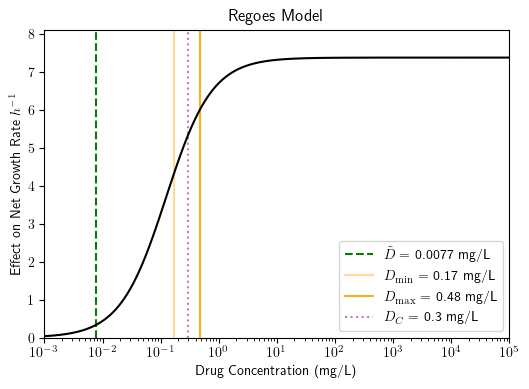

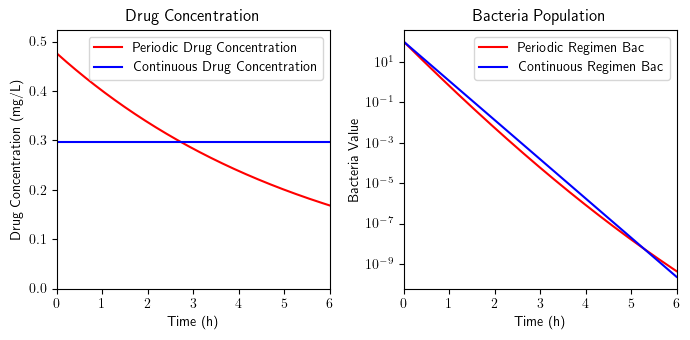

In [3]:
# specify PD model and antibiotic:

PD_model = "Regoes"  # options: "linear", "Regoes", "E_max"
drug_name = "Ciprofloxacin"  # name of drug (optional)

# input dose response curve data here (only need to fill in the relevant
# parameters for the chosen PD model):

# linear parameters: necessary if PD_model="linear"
G_max = 0  # maximum net growth rate in absence of antibiotic (h^-1)
slope = 0  # slope of linear dose response curve

# Regoes parameters: necessary if PD_model="Regoes"
kappa = 1.1  # Hill coefficient
p_max = 0.88  # maximum (net) growth rate in absence of antibiotic (h^-1)
p_min = -6.5  # minimum (net) growth rate in presence of antibiotic (h^-1)
MIC = 0.02  # minimum inhibitory concentration of antibiotic (mg/L)


# E_max parameters: necessary if PD_model="E_max"
hill_coeff = 0  # Hill coefficient
G_max = 0  # maximum net growth rate in absence of antibiotic (h^-1)
E_max = 0  # maximum drug response (h^-1)
EC_50 = 0  # drug concentration at half-maximum drug response (mg/L)

# input PD parameters for decay model here:

half_life = 4  # half-life of antibiotic (h)
p_dose = 100  # dose size for periodic regimen (mg)
dose_period = 6  # dose period for periodic regimen (h)
volume = 210  # volume of distribution (L)

# toggle if needed for solving IVP:
# if you want to graph the y-axis as percent of initial bacteria, set
# initial_bac=100 and tol<=min_bac

initial_bac = 100  # initial bacteria value, default to 1e10.
min_bac = 1e-12  # stops integration at this value, default to 1.
tol = 1e-13  # tolerance for IVP solver, default to 1e-6. tol<min_bac necessary

# do not edit below this line ----------------------------------------------

params = par.parameters(
    PD_model=PD_model,
    drug_name=drug_name,
    G_max=G_max,
    slope=slope,
    kappa=kappa,
    p_max=p_max,
    p_min=p_min,
    MIC=MIC,
    hill_coeff=hill_coeff,
    E_max=E_max,
    EC_50=EC_50,
    half_life=half_life,
    p_dose=p_dose,
    dose_period=dose_period,
    volume=volume,
    initial_bac=initial_bac,
    min_bac=min_bac,
    tol=tol,
)

fun.regimen_analysis(params)